Tuned AUC: 0.745, F1: 0.828, Accuracy: 0.766
Test Set Accuracy: 0.745


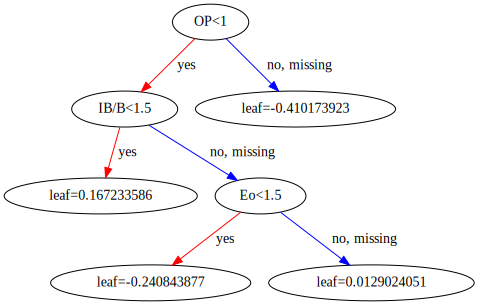

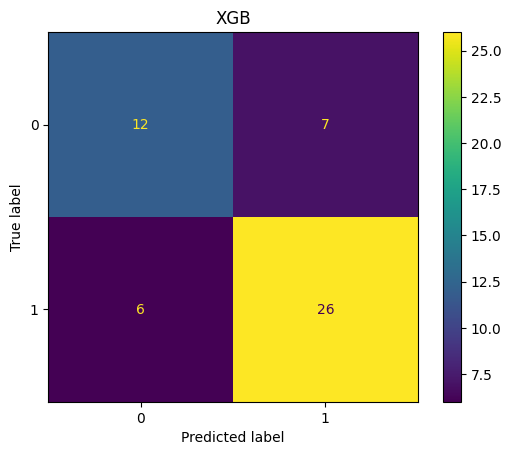

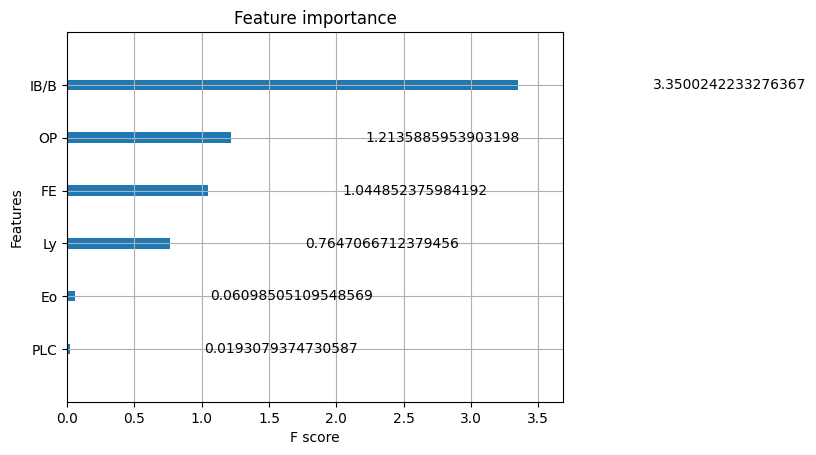

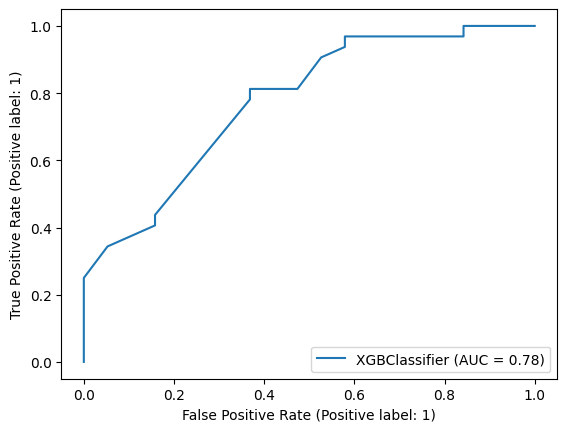

In [6]:
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold, cross_validate, train_test_split
import pandas as pd
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_auc_score, f1_score

data = pd.read_excel("~/projects/Sano/sanoproject_ENO.xlsx",sheet_name="fukuoka", index_col="ID")
data = data[data.target != 3]
data["maligvsbenign"] = [1 if x<3 else 0 for x in data.target]
data["Sex"] = [1 if x == "F" else 0 for x in data.Sex]
X = data[['intbronch','plasmacellinfil', 'eosinoinfil', 'lymphoidagg', 'fibroelastosis', 'op',]]
X = X.rename(columns={'intbronch':"IB/B",
                       'plasmacellinfil':"PLC",
                       'eosinoinfil':"Eo",
                       'lymphoidagg':"Ly",
                       'fibroelastosis':"FE",
                       'op':"OP",
                       })
y = data["maligvsbenign"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=data["target"], random_state=184)


clf = xgb.XGBClassifier(gamma = 0.0001, 
                        learning_rate = 1, 
                        max_depth = 3,
                        min_child_weight = 1,
                        n_estimators = 1000,
                        objective = "binary:logistic",
                        reg_alpha = 1,
                        reg_lambda = 1,
                        subsample = 1,
                        tree_method = "hist",)

scorers = {"AUC":"roc_auc",
            "f1":"f1",
            "Accuracy":"accuracy"}

scores = cross_validate(clf, 
                        X_train, y_train, 
                        scoring=scorers,
                        cv=RepeatedKFold(n_splits=10, n_repeats=100, random_state=84),
                        n_jobs=-1)

print(f"Tuned AUC: {scores['test_AUC'].mean():.3f}, F1: {scores['test_f1'].mean():.3f}, Accuracy: {scores['test_Accuracy'].mean():.3f}")
trainedclf = clf.fit(X_train, y_train)
preds = trainedclf.predict(X_test)

print(f"Test Set Accuracy: {trainedclf.score(X_test,y_test):.3f}")

cm = ConfusionMatrixDisplay.from_predictions(y_test, preds).ax_.set_title("XGB")

xgb.plot_importance(trainedclf, importance_type="gain")
RocCurveDisplay.from_estimator(trainedclf, X_test, y_test)
xgb.to_graphviz(trainedclf, num_trees=3)